# Demos


## Manifold analysis example

Example of manifold analysis in Figure 5d,e and
Supplementary figure 5e-h.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Here we load the PC linear model data (Supplementary figure 3c,d)
mf_data = pd.read_excel('../data/SupplementaryFigure3.xlsx',
                       sheet_name='Figure S3b,c,d,f',
                       usecols='A:HY',
                       skiprows=2,
                       nrows=502)

pc_data = pd.read_excel('../data/SupplementaryFigure3.xlsx',
                       sheet_name='Figure S3b,c,d,f',
                       usecols='HZ:TP',
                       skiprows=2,
                       nrows=502)



In [3]:
import cbmanifold
from cbmanifold.linear_model import LinearModel

def source_data_to_LinearModel(data, label):
    _, n = data.shape
    n = (n - 1) // 2

    scale = 1e3  # kHz -> Hz

    rate = data.iloc[:, 0:n].values.T * scale
    drate = data.iloc[:, n : 2 * n].values.T * scale
    v0 = data.iloc[:, 2 * n].unique()[0]
    n_params = 1
    lm = LinearModel(
        rate=rate,
        drate=drate,
        label=label,
        params0 = [v0]
    )
    lm.n_params = n_params


    return lm


lm_mf = source_data_to_LinearModel(mf_data, "mossy fiber")
lm_pc = source_data_to_LinearModel(pc_data, "Purkinje cell")

figsize: [6. 5.]


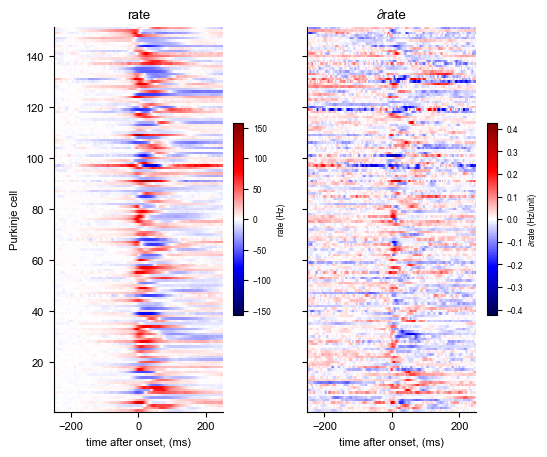

In [4]:
_, _ = cbmanifold.plot.plot_linear_model(lm_pc)

Dimensions: 1, Variance explained: 51.04384881006197
Dimensions: 2, Variance explained: 76.07985014983356
Dimensions: 3, Variance explained: 85.97231371969616
Dimensions: 4, Variance explained: 92.25990202100004
Dimensions: 5, Variance explained: 94.64670779103892
Dimensions to be reduced: 4


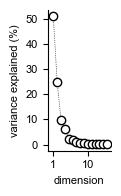

In [5]:
from cbmanifold.decomposition import pmPCA

dd, p, v = pmPCA(lm_pc.rate)
var_explained = dd/np.sum(dd)*1e2;
var_explained_cumsum = np.cumsum(var_explained);
for i in range(5):
    print(f'Dimensions: {i+1}, Variance explained: {var_explained_cumsum[i]}')

nmode = np.where(var_explained_cumsum > 87.5)[0][0]+1
print(f'Dimensions to be reduced: {nmode}')

_ = cbmanifold.plot.plot_var_explained(var_explained)


In [44]:
lmr = cbmanifold.decomposition.reduce_dimensionality(lm_pc, 4)
lmr = cbmanifold.utils.flip_sign(lmr, [1]) # flip signs to make the cycles go CCW

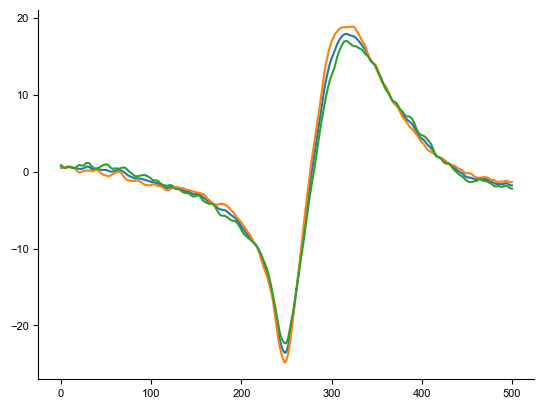

In [45]:
i = 1
plt.plot(0*lmr.dp[i,:]+lmr.p[i,:])
plt.plot(70*lmr.dp[i,:]+lmr.p[i,:])
plt.plot(-70*lmr.dp[i,:]+lmr.p[i,:])


(-30.0, 30.0)

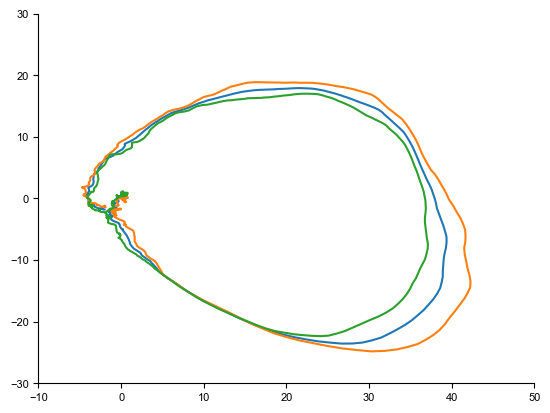

In [46]:
i1, i2 = 0, 1
plt.plot(0*lmr.dp[i1,:]+lmr.p[i1,:], 0*lmr.dp[i2,:]+lmr.p[i2,:])
plt.plot(70*lmr.dp[i1,:]+lmr.p[i1,:], 70*lmr.dp[i2,:]+lmr.p[i2,:])
plt.plot(-70*lmr.dp[i1,:]+lmr.p[i1,:], -70*lmr.dp[i2,:]+lmr.p[i2,:])
plt.xlim([-10, 50])
plt.ylim([-30, 30])


In [9]:
lmr

LinearModel(label='Purkinje cell', rate=array([[-0.37561891, -0.29563845, -0.23179841, ...,  0.6380616 ,
         0.75234   ,  0.8383616 ],
       [ 1.22964624,  1.24102209,  1.21261757, ..., -3.90484741,
        -3.87467699, -3.73667259],
       [ 1.84681647,  1.81633593,  1.7422342 , ..., -5.54854167,
        -5.57361504, -5.4394008 ],
       ...,
       [-1.65574828, -1.61072665, -1.53259539, ...,  4.85687988,
         4.905543  ,  4.81239106],
       [-1.2343765 , -1.19706335, -1.13633762, ...,  3.59593027,
         3.63775688,  3.57406935],
       [ 1.33741732,  1.32616701,  1.27965829, ..., -4.09005476,
        -4.09219685, -3.9783796 ]], shape=(151, 501)), drate=None, params0=[np.float64(591.3913)], is_dim_reduced=True)

## Linear model construction

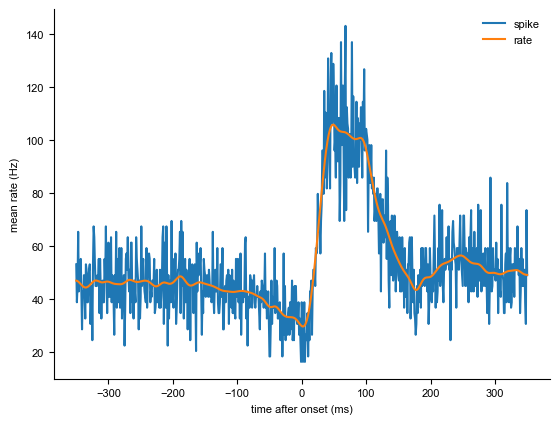

In [47]:
import scipy.io as io

pc3_data = io.loadmat('../data/PC3.mat')

#time
t = pc3_data['t'].ravel()

# spikes
ss = pc3_data['ss']*1e3

# peak velocity
pv = pc3_data['v'].ravel()

# duration
dur = pc3_data['dur'].ravel()
av = 15./dur*1e3 # average velocity

# rate, gaussian filtered with sigma=7
rate = cbmanifold.utils.filter_matrix(ss.T, sigma=7).T

_, ax = plt.subplots()
ax.plot(t, ss.mean(axis=0), label='spike')
ax.plot(t, rate.mean(axis=0), label='rate')
ax.set(xlabel='time after onset (ms)', ylabel='mean rate (Hz)')
ax.legend()

In [48]:
# grand average of pv and av, from Markanday et al. 2023
pv0 = 591.3913
av0 = 352.6262

# single parameter model
params = np.vstack([pv]).T # should be n_trials x 1
lm = cbmanifold.linear_model.generate_linear_model('pc3', rate, params, [pv0],output_type="LinearModel")

[Text(0.5, 0, 'Time after onset (ms)'), Text(0, 0.5, 'rate (Hz)')]

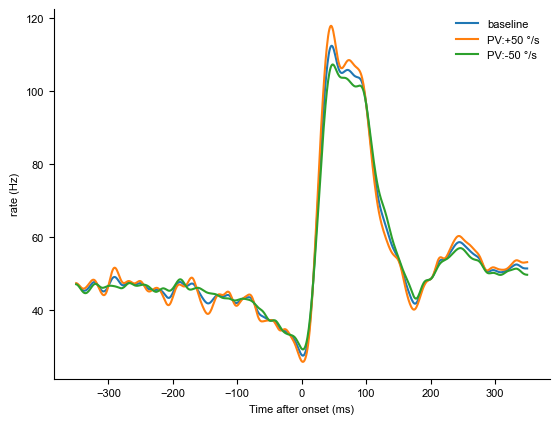

In [49]:
_, ax = plt.subplots()

# Plot baseline (kinematics-independent rate)
ax.plot(t, lm.rate, label='baseline')

# Plot +50 °/s change
params_high = lm.params0.copy()
params_high[0] += 50  # increase peak velocity by 50
rate_high = lm.predict(params_high)
ax.plot(t, rate_high, label='PV:+50 °/s')

# Plot -50 °/s change
params_low = lm.params0.copy()
params_low[0] -= 50  # decrease peak velocity by 50
rate_low = lm.predict(params_low)
ax.plot(t, rate_low, label='PV:-50 °/s')

ax.legend()
ax.set(xlabel='Time after onset (ms)', ylabel='rate (Hz)')

In [59]:
# two parameter model --- Now generate the model in a dict type
params = np.vstack([pv, av]).T  # should be n_trials x 2
lm = cbmanifold.linear_model.generate_linear_model('pc3',
    rate, params, [pv0, av0], output_type="dict"
)

In [60]:
lm

{'label': 'pc3',
 'rate': array([ 48.65161129,  48.53626584,  48.31601749,  48.00850335,
         47.63743272,  47.23312887,  46.82759637,  46.45289611,
         46.13818153,  45.9084284 ,  45.78317737,  45.77360339,
         45.88282296,  46.10847834,  46.44195864,  46.86766981,
         47.36787885,  47.922067  ,  48.50930435,  49.10652821,
         49.69190801,  50.24457697,  50.74532049,  51.17389338,
         51.51499098,  51.75470796,  51.88417174,  51.89573783,
         51.79049294,  51.57303908,  51.25302671,  50.84568368,
         50.36961746,  49.84553027,  49.29535242,  48.74051848,
         48.19994925,  47.69018163,  47.2248533 ,  46.81385571,
         46.46373566,  46.17906343,  45.9630232 ,  45.81540817,
         45.73567206,  45.72396229,  45.77906141,  45.89568369,
         46.07069801,  46.29905893,  46.57353571,  46.8855454 ,
         47.2246408 ,  47.58119254,  47.94479832,  48.30447839,
         48.65015328,  48.97459707,  49.26715695,  49.52001758,
         49.727

Text(0.0, -0.5, 'Peak firing rate is more dependent on AV (=15°/duration) rather than PV. This was not seen in the previous plot since AV and PV are positively correlated.')

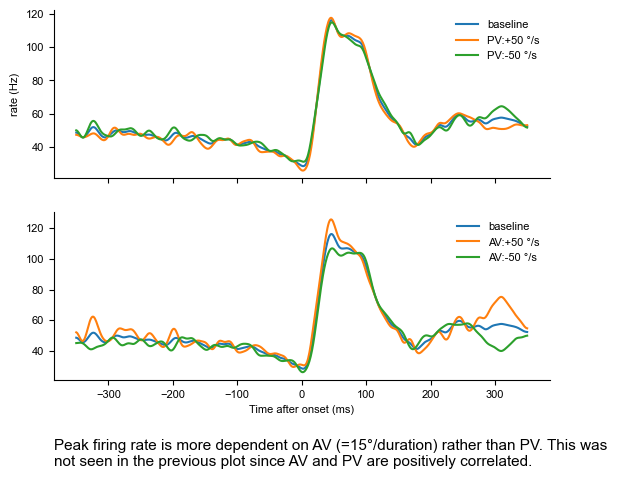

In [63]:
# a dictionary type model can be converted to a LinearModel type.
lmc = cbmanifold.linear_model.LinearModel.from_dict(lm)

_, ax = plt.subplots(nrows=2, sharex=True)

# Top panel - Peak Velocity changes
ax[0].plot(t, lmc.rate, label="baseline")

# PV +50
params_high_pv = lmc.params0.copy()
params_high_pv[0] += 50  # increase peak velocity by 50
rate_high_pv = lmc.predict(params_high_pv)
ax[0].plot(t, rate_high_pv, label="PV:+50 °/s")

# PV -50
params_low_pv = lmc.params0.copy()
params_low_pv[0] -= 50  # decrease peak velocity by 50
rate_low_pv = lmc.predict(params_low_pv)
ax[0].plot(t, rate_low_pv, label="PV:-50 °/s")

ax[0].legend()
ax[0].set_ylabel("rate (Hz)")

# Bottom panel - Average Velocity changes
ax[1].plot(t, lmc.rate, label="baseline")

# AV +50
params_high_av = lmc.params0.copy()
params_high_av[1] += 50  # increase average velocity by 50
rate_high_av = lmc.predict(params_high_av)
ax[1].plot(t, rate_high_av, label="AV:+50 °/s")

# AV -50
params_low_av = lmc.params0.copy()
params_low_av[1] -= 50  # decrease average velocity by 50
rate_low_av = lmc.predict(params_low_av)
ax[1].plot(t, rate_low_av, label="AV:-50 °/s")

ax[1].legend()
ax[1].set_xlabel("Time after onset (ms)")

# Add explanatory text
ax[1].text(0.0, -0.5,
    """Peak firing rate is more dependent on AV (=15°/duration) rather than PV. This was not seen in the previous plot since AV and PV are positively correlated.""",
    transform=ax[1].transAxes,
    wrap=True,
    size=11
)

Text(0, 0.5, 'AV (°/s)')

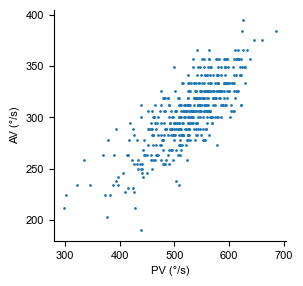

In [32]:
_, ax = plt.subplots(figsize=(3, 3))

ax.scatter(params[:,0], params[:,1], 1)
ax.set_xlabel('PV (°/s)')
ax.set_ylabel('AV (°/s)')


## Linear model construction - old way

The code above is based on a revised version of the generation. The old way is still available.

In [54]:
# note that the old way received duration as a parameter
params_old = np.vstack([pv, dur]).T

lmol = cbmanifold.linear_model.generate_linear_model_old('pc3', rate, params_old, [pv0, av0], target_dist=15, output_type="dict")

lm = cbmanifold.linear_model.LinearModel.from_dict(lmol)

[Text(0.5, 0, 'Time after onset (ms)'), Text(0, 0.5, 'rate (Hz)')]

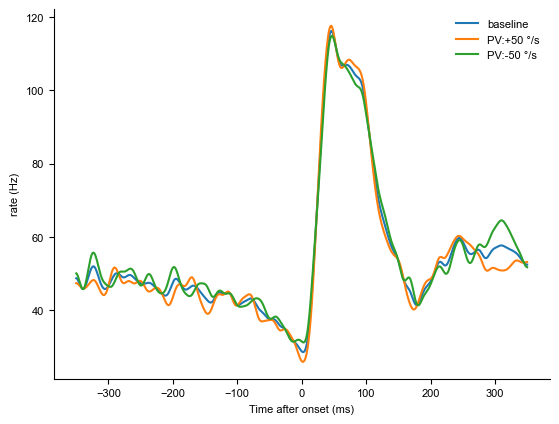

In [56]:
_, ax = plt.subplots()

# Plot baseline (original rate)
ax.plot(t, lm.rate, label='baseline')

# Plot +50 °/s change
params_high = lm.params0.copy()
params_high[0] += 50  # increase peak velocity by 50
rate_high = lm.predict(params_high)
ax.plot(t, rate_high, label='PV:+50 °/s')

# Plot -50 °/s change
params_low = lm.params0.copy()
params_low[0] -= 50  # decrease peak velocity by 50
rate_low = lm.predict(params_low)
ax.plot(t, rate_low, label='PV:-50 °/s')

ax.legend()
ax.set(xlabel='Time after onset (ms)', ylabel='rate (Hz)')

Text(0.5, 1.0, 'This is the same result as the new way')

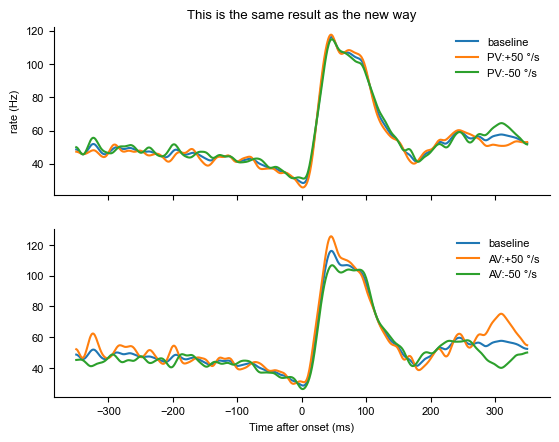

In [57]:
_, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(t, lm.rate, label="baseline")
ax[0].plot(t, lm.rate + lm.wv * 50, label="PV:+50 °/s")
ax[0].plot(t, lm.rate - lm.wv * 50, label="PV:-50 °/s")
ax[0].legend()
ax[0].set_ylabel("rate (Hz)")

ax[1].plot(t, lm.rate, label="baseline")
ax[1].plot(t, lm.rate + lm.wr * 50, label="AV:+50 °/s")
ax[1].plot(t, lm.rate - lm.wr * 50, label="AV:-50 °/s")
ax[1].legend()
ax[1].set_xlabel("Time after onset (ms)")

ax[0].set_title(
    """This is the same result as the new way""")